In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import config
import utility.df
import utility.iolib
import utility.plotlib

#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

In [2]:
# Setup configuration
cfg = config.ResearchConfig
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

Complete loading data for subscription and lesson history!


In [3]:
pupil_list_mon = df_subspt[df_subspt.subscription_type==cfg.TYPE_MONTHLY].pupilId.unique()
pupil_list_ann = df_subspt[df_subspt.subscription_type==cfg.TYPE_ANNUAL].pupilId.unique()
print('Number of mon/thly subscribers = {}'.format(len(pupil_list_mon)))
print('Number of annual subscribers = {}'.format(len(pupil_list_ann)))

Number of mon/thly subscribers = 3504
Number of annual subscribers = 2525


In [4]:
df_usage = utility.df.customer_usage(df_subspt, df_lesson, df_incomp, cfg)

The usage has already been computed and saved in a file. The file has been loaded!


In [5]:
df_usage.set_index(['pupilId', 'date'], inplace=True)

# Progressions

In [6]:
# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=False)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

In summary, there are 1380/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 4305/4305 [00:12<00:00, 351.28it/s]


In [7]:
# Remove 'replay' lesson type - progressions will always be recorded as 0
df_lesson1_nr = df_lesson1[df_lesson1['lesson_type']!='replay']

# Taken the largest progression number for a day
max_progress = df_lesson1_nr.groupby(['pupilId', df_lesson['marked'].dt.date])['progressions'].max()
# Compute the daily progression delta
delta_progress = max_progress.groupby(level=0).diff()
df_lesson_progress = pd.DataFrame({'progressions': max_progress, \
                                   'progressions_delta': delta_progress})
def set_first_value(df):
    df['progressions_delta'].iloc[0] = df['progressions'].iloc[0]
    return df

df_lesson_progress = df_lesson_progress.groupby(level=0).apply(set_first_value)
df_lesson_progress.reset_index(level=1, inplace=True)
df_lesson_progress.rename(columns={'marked' : 'date'}, inplace=True)

#df_lesson_progress.reset_index(inplace=True)

In [8]:
def remove_trial_period(df):
    subspt_start_date = df_subspt1[df_subspt1['pupilId']==df.name]['subscription_start_date'].min()
    return df[df['date'] >= subspt_start_date.date()]

df_lesson_progress = df_lesson_progress.groupby(level=0).apply(remove_trial_period)
df_lesson_progress.reset_index(level=0, drop=True, inplace=True)
df_lesson_progress.set_index(['date'], append=True, inplace=True)

# Features

In [9]:
# Combine df
df_features = pd.concat([df_usage, df_lesson_progress], axis=1)

# Fill nan for 'progressions' field 
df_features['progressions'] = df_features.groupby(level=0)['progressions'].apply(lambda x: x.ffill())
df_features['progressions'].fillna(0, inplace=True)

# Fill nan for 'progressions_delta' field
df_features['progressions_delta'].fillna(0, inplace=True)

df_features['time_taken'] = df_features['time_taken_complete'] + df_features['time_taken_incomplete']

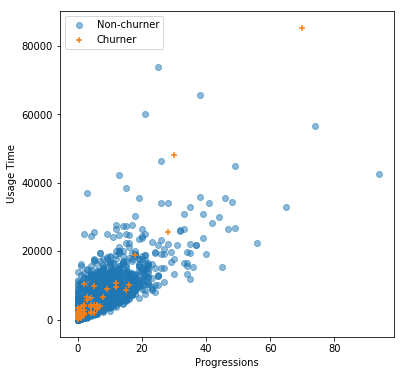

In [141]:
study_month = 5

df_features1 = df_features[df_features['customer_month']==study_month]

progress = df_features1.groupby(level=0)['progressions_delta'].sum()
usage = df_features1.groupby(level=0)['time_taken'].sum()

pupils_nextMonth = df_subspt1[df_subspt1['customer_month']==(study_month+1)]['pupilId'].unique()
pupils_nextAnnual = df_subspt1[df_subspt1['customer_month']==(study_month+12)]['pupilId'].unique()
pupils_nextMonthRenew = np.union1d(pupils_nextMonth, pupils_nextAnnual)

pupils_thisMonth = df_subspt1[df_subspt1['customer_month']==study_month]['pupilId'].unique()
pupils_nextMonthCancel = np.setdiff1d(pupils_thisMonth, pupils_nextMonthRenew)

df_agg = pd.DataFrame({'progress': progress, 'usage': usage})

df_agg['next_month_cancel'] = 0
df_agg.loc[df_agg.index.isin(pupils_nextMonthCancel), 'next_month_cancel'] = 1

fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)

ax.scatter(df_agg[df_agg.next_month_cancel==0].progress, df_agg[df_agg.next_month_cancel==0].usage, alpha=0.5, label='Non-churner')
ax.scatter(df_agg[df_agg.next_month_cancel==1].progress, df_agg[df_agg.next_month_cancel==1].usage, marker='+', label='Churner')
ax.set_xlabel('Progressions')
ax.set_ylabel('Usage Time')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()

In [142]:
from sklearn import linear_model

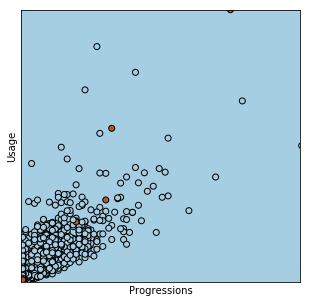

In [143]:
logreg = linear_model.LogisticRegression(C=1)
X = df_agg[['progress', 'usage']]
y = df_agg['next_month_cancel']

logreg.fit(X,y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X.iloc[:, 0].min() - .5, X.iloc[:, 0].max() + .5
y_min, y_max = X.iloc[:, 1].min() - .5, X.iloc[:, 1].max() + .5

xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 100))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(5, 5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Progressions')
plt.ylabel('Usage')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [144]:
import seaborn as sns

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


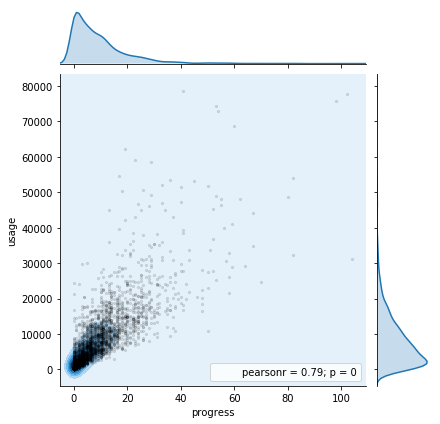

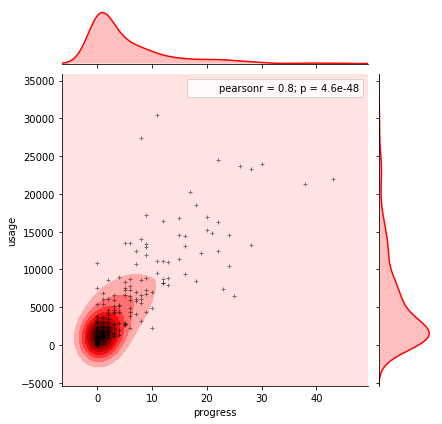

In [146]:
g1 = sns.jointplot(x='progress', y='usage', data=nonchurner[['progress', 'usage']], kind='kde')
g1.plot_joint(plt.scatter, c="k", s=5, linewidth=1, marker="o", alpha=0.1)

g2 = sns.jointplot(x='progress', y='usage', data=churner[['progress', 'usage']], kind='kde', color='r')
g2.plot_joint(plt.scatter, c="k", s=10, linewidth=1, marker="+", alpha=0.5)